# Numerical solution of the time-independent and time-dependent Schrödinger equations: basis representation of the wave function

### Imports, initialization.

In [150]:
# Imports
import numpy as np
import scipy as sp
import scipy.integrate as spi
from scipy.integrate import complex_ode, ode

import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Copyright (C) 2020, Oriol Vendrell <oriol.vendrell@uni-heidelberg.de>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

## Time-Independent Schrödinger Equation for Unbound States in 1D

In this notebook we solve the 1D TISE

\begin{align}
    \hat{H}_0 \psi(x) & = E\psi(x) \\
    \frac{-\hbar^2}{2m}\frac{d^2}{dx^2}\psi(x) + V(x)\psi(x) & = E\psi(x)
\end{align}

using a basis representation for bound states. As a basis, we will use the eigenfunctions of the particle in a box (p-box) in the domain where we seek the solution. Remember, the basis of eigenstates of the p-box is complete. The number of basis functions $N_b$ is our convergence parameter.

### Input parameters

In [151]:
L     = 1.0    # Box length
m     = 100.0  # particle's mass
Q     = -1.0   # particles's charge
Np    = 150    # Number of real space points in segment
Nb    = 40     # Number of basis functions (pbox solutions)
step  = 1.0    # Height of step function (Hartree)
istep = 0.3    # Start of step (position)
fstep = 0.4    # End of step (position)
A0    = 0.1    # Amplitude of constant electric field
At    = 10.0   # Amplitude of time-dependent electric field

In [152]:
# X is the array with the grid point positions.
# This is our discretization grid on which the matrix elements are numerically calculated
X = np.linspace(0,L,Np)

### Particle in a box energies and eigenstates

Particle in a box energy $$E_n = \frac{\hbar^2 \pi^2}{2 m L^2} n^2$$

In [153]:
# particle in a box analytical energy for level n (n>=1)
def pbox_a_energy(n): # particle in a box analytical energy for level n (n>=1)
    """
    Return the analytical p-box energy for the n-th eigenstate
    """
    return np.pi**2/(2*m*L**2)*n**2

In [154]:
# particle in a box eigenstates on the real space grid; j>=1 !!
def pbox_basis(n):
    """
    Return the n-th basis function on the discretization grid
    
    n: int. quantum number
    """
    y = np.zeros(Np)
    for i,xx in enumerate(X):
        if xx < L or xx > 0.0:
            y[i] = np.sqrt(2.0/L)*np.sin(n*np.pi*xx/L)
    return y

In [155]:
# For each basis function, put the amplitude at each position in a list, convert to matrix
Blist = []
for i in range(Nb):
    Blist.append(pbox_basis(i+1))
B = np.array(Blist)

### Hamiltonian and potential energy operator on the real space grid

The Hamiltonian $\hat{H}$ reads

$$H = H_0 + V_s(x) - q_e (x-\frac{L}{2})\epsilon$$

where $V_s(x)$ is a rectangular step function and the term $q_e (x-\frac{L}{2})\epsilon$ describes the electric potential energy of a charged particle with a constant electric field of amplitude $\epsilon$.

In [156]:
# Particle (electron) in a box with step function potential and constant electric field
def Vfunc():
    v = np.zeros(Np)
    for i,xx in enumerate(X):
        if xx > istep and xx < fstep:
            v[i] = step
        v[i] = v[i] - Q*(xx - 0.5*L)*A0
    return v

In [157]:
V = Vfunc()

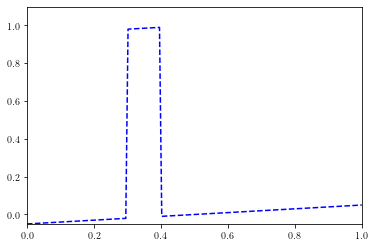

In [158]:
# Plot the potential
plt.xlim(min(X),max(X))
plt.ylim((min(V),max(1,step+step*0.1)))
plt.plot(X,V, linestyle='--', color='b')

### Matrix elements of the Hamiltonian operator

$$V_{ij}=\int_0^L \phi_i^*(x) V(x) \phi_j dx$$

In [159]:
def matrix_element_V(i,j):
    """
    Return matrix element of the potential for indices i, j
    The integration uses a simple Simpson integrator
    
    i,j: quantum numbers of the basis states (lowest index = 0, not 1!)
    """
    return spi.simps(B[i]*V*B[j],X)

In [160]:
# Put matrix elements of the potential into the matrix Vop
Vop = np.zeros((Nb,Nb),float)
for i in range(Nb):
    for j in range(Nb):
        Vop[i,j] = matrix_element_V(i,j) # 

$$ T_{ij} = \frac{-\hbar^2}{2m} \int_0^L \phi_i(x) \frac{d^2}{dx^2} \phi_j(x) dx $$

In [161]:
def pbox_basis2(n):
    """
    Return the 2nd derivative of the n-th basis function on the discretization grid
    
    n: int. quantum number
    """
    y = np.zeros(Np)
    for i,xx in enumerate(X):
        if xx < L or xx > 0.0:
            y[i] = (0.5/m)*np.sqrt(2.0/L)*(n*np.pi/L)**2*np.sin(n*np.pi*xx/L)
    return y
    

In [162]:
def matrix_element_T(i,j):
    """
    Return matrix element of the kinetic energy for indices i, j
    The integration uses a simple Simpson integrator
    
    i,j: quantum numbers of the basis states (lowest index is 0, not 1!)
    """
    return spi.simps(B[i]*pbox_basis2(j+1),X)

In [163]:
# Put matrix elements of the kinetic energy into the matrix Top
Top = np.zeros((Nb,Nb),float)
for i in range(Nb):
    for j in range(Nb):
        Top[i,j] = matrix_element_T(i,j)

$$H_{ij} = T_{ij} + V_{ij}$$

### Build and diagonalize Hamiltonian matrix

In [164]:
H = Top + Vop

In [165]:
evals,evecs = np.linalg.eig(H)

In [166]:
# Sort eigenvalues and eigenvactors from lowest to highest energy
evecs[:] = evecs.take(evals.argsort(),axis=1) # axis=1: eigenvectors are stored as the columns of the evecs 2D array
evals[:] = evals.take(evals.argsort())

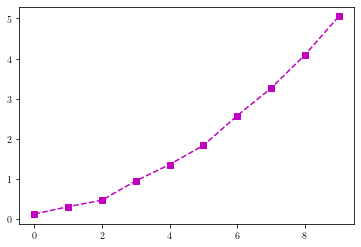

In [167]:
plt.plot(evals[:10],marker='s', linestyle='--', color='m')

### Eigenfunctions in the perturbed box

The eigenvectors evecs[:,k] contain the expansion coefficients $c_j^{(k)}$ of the $k$-th state in the perturbed box (with the step potential and electric field) in terms of the orthogonal basis we have chosen, namely the eigenstates of the ``flat" particle in a box $\phi_j(x)$:
$$ \psi_k(x) = \sum_j^{Nb} c_j^{(k)} \phi_j(x) $$
The plot below shows on a log scale $\log(|c_j^{(k)}|^2)$ for selected eigenstates $k$.

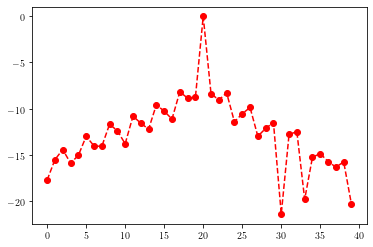

In [168]:
#ylim((0,1))
k=20
plt.plot(range(0,Nb),np.log(np.abs(evecs[:,k])**2),marker='o', linestyle='--', color='r')

### Graphical representation of the eigenfunctions

Let us refer to the __evecs__ 2D array as $\mathbf{C}$, where $C_{j,k} = c_j^{(k)}$, the $j$-th basis coefficient of the $k$-th eigenstate. Note that the _columns_ of $\mathbf{C}$ correspond to the eigenvectors and therefore the eigenvalue equation can be written for all eigenvectors together as

$$ \mathbf{H} \mathbf{C} = \mathbf{E} \mathbf{C} $$

where $\mathbf{E}$ is a diagonal matrix with all eigenenergies.

Above, we also stored the position-dependent amplitude of each basis function in the matrix $\mathbf{B}$:

$$
    B_{j,a} = \phi_j(x_a)
$$

With the matrix of expansion coefficients $\mathbf{C}$ and the position representation of the basis states $\mathbf{B}$, we can now find the position representation of each basis state, and equivalently, we can project any function in position representation onto our basis $\phi_j(x)$:

$$
    \psi_k(x_a) = \sum_j^{N_b} B_{j,a} C_{j,k}
$$

This can be more compactly written as

$$
    \mathbf{\Psi}_\mathbf{X} = \mathbf{B}^\intercal \mathbf{C}
$$

where the _columns_ of $\mathbf{\Psi}_\mathbf{X}$ contain the amplitudes of the $k$-th eigenstate for each position, $\psi_k(x_a)$.

In [171]:
psiX = np.dot(np.transpose(B), evecs)

In the same way, for $F_X = \left( a_1, a_2, \ldots a_{Np}\right)^\intercal$ being the vector of amplitudes of function $F(x)$ at each grid position, its coefficients representation is found via the linear transformation:

$$
    F_C = \mathbf{B} \;F_X
$$

In [170]:
# Spatial representation to coefficients
def psi_grid2coeff(fx):
    """
    fx: array, vector with real space representation
    """
    fc = np.dot(B,fx)
    return fc

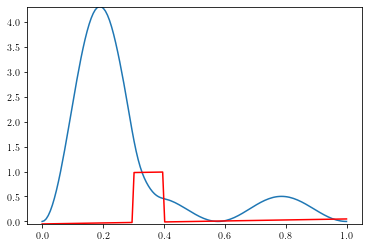

In [173]:
# Try k = 0, 1,...
k = 1
p = psiX[:,k]
p2 = np.abs(p)**2

vmax = max(V)
p2max = max(p2)
fact = p2max/(vmax+0.01)
plt.ylim(min(V),p2max)
plt.plot(X,p2)
plt.plot(X,V, linestyle='-', color='r')